In [55]:
import axelrod as axl

import pandas as pd
from pathlib import Path
import sequence_sensei

In [2]:
import tqdm

In [4]:
import keras
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.models import Sequential

In [5]:
import matplotlib.pyplot as plt

In [6]:
import imp

player_class = imp.load_source('player_class', 'player_class.py')

In [7]:
import numpy as np

In [8]:
from keras.layers.embeddings import Embedding

**Padded Classification**

In [9]:
inputs = pd.read_csv("data/basic_padded_inputs_classification.csv", index_col=0)
outputs = pd.read_csv("data/basic_classification_output.csv", index_col=0)

In [10]:
X = inputs.values
y = outputs.values

In [11]:
max_length = len(X[0])
batch_size = 64
num_of_epochs = 1

num_cells = 200
drop_out_rate = 0.2

In [12]:
top_words = 3
embedding_vecor_length = 1

In [14]:
model = Sequential()

model.add(Embedding(top_words, embedding_vecor_length, input_length=max_length))
model.add(Bidirectional(LSTM(num_cells)),
        )

model.add(Dropout(rate=drop_out_rate))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"]
)

In [16]:
history = model.fit(
    x=X,
    y=y,
    batch_size=batch_size,
    epochs=num_of_epochs,
    verbose=1,
    validation_split=0.1
)

Train on 15422 samples, validate on 1714 samples
Epoch 1/1
15422/15422 [==============================] - 241s 16ms/step - loss: 0.5617 - acc: 0.7400 - val_loss: 0.3972 - val_acc: 0.7287


In [32]:
X[1], y[1]

(array([2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]), array([0]))

In [29]:
test_input = X[1].reshape(1, 204)

In [30]:
model.predict(test_input)

array([[0.5069026]], dtype=float32)

In [ ]:
validation_from_siren = pd.read_csv('output_basic_tournament/basic/output_padded/')

**Unknown lenght**

In [34]:
from sklearn.model_selection import train_test_split

In [78]:
def batch_generator(inputs, outputs):
    while True:
        for size in range(1, 205):
            batches = [
                (sequence, target)
                for sequence, target in zip(inputs, outputs)
                if len(sequence) == size
            ]

            x, y = zip(*batches)
            batch = np.array(x)
            output_batch = np.array(y)

            try:
                batch = batch.reshape((batch.shape[0], batch.shape[1], 1))
                output_batch = output_batch.reshape(
                    (output_batch.shape[0], output_batch.shape[1], 1)
                )
            except IndexError:
                batch = batch.reshape((batch.shape[0], 1, 1))
                output_batch = output_batch.reshape(
                    (output_batch.shape[0], 1, 1)
                )

            yield batch, output_batch


def format_sequences_to_input(sequences):
    inputs = sequences.drop(columns=["opponent", "gene_204"]).values
    max_length = len(inputs[0])

    prep_X_train = []
    for histories in range(1, max_length + 1):
        for sequence in inputs:
            assert len(sequence) == max_length
            prep_X_train.append(sequence[:histories])

    return np.array(prep_X_train)

def format_sequences_to_output(sequences):
    inputs = sequences.drop(columns=["opponent", "gene_0"]).values
    max_length = len(inputs[0])

    prep_y_train = []
    for histories in range(1, max_length + 1):
        for sequence in inputs:
            assert len(sequence) == max_length
            prep_y_train.append(sequence[:histories])

    return np.array(prep_y_train)

In [79]:
outputs = pd.read_csv("data/basic_targets.csv", index_col=0)
y = format_sequences_to_output(outputs)

sequences = pd.read_csv("data/basic_sequences.csv", index_col=0)
inputs = format_sequences_to_input(sequences)

In [80]:
input_train, input_test, output_train, output_test = train_test_split(
    inputs, y, test_size=0.2, random_state=0
)

In [90]:
trainGen = batch_generator(input_train, output_train)
testGen = batch_generator(input_test, output_test)

In [91]:
number_of_epochs = 1

In [92]:
model = Sequential()

model.add(LSTM(
            100, return_sequences=True, input_shape=(None, 1)
        )
    )

model.add(Dropout(rate=drop_out_rate))

model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]
)

history = model.fit_generator(
    trainGen,
    steps_per_epoch=204,
    epochs=number_of_epochs,
    verbose=1,
    validation_data=testGen,
    validation_steps=204,
)

Epoch 1/1
204/204 [==============================] - 24s 120ms/step - loss: 0.3819 - acc: 0.8248 - val_loss: 0.3072 - val_acc: 0.8861


In [46]:
validation_from_siren = pd.read_csv('output_basic_tournament/basic/output_lstm/validation_measures_run_100_5.csv')

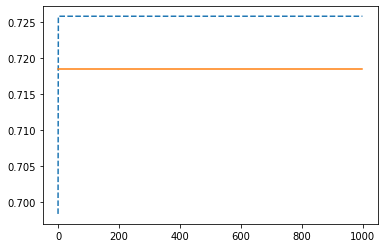

In [53]:
plt.plot(validation_from_siren['acc'], "--");
plt.plot(validation_from_siren['val_acc']);

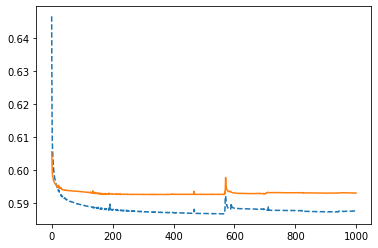

In [54]:
plt.plot(validation_from_siren['loss'], "--");
plt.plot(validation_from_siren['val_loss']);